In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, MaxPooling1D, AveragePooling1D
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.7053025658242404e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, True,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 5) (80000, 6, 1) (80000, 9)
(20000, 6, 5) (20000, 6, 1) (20000, 9)


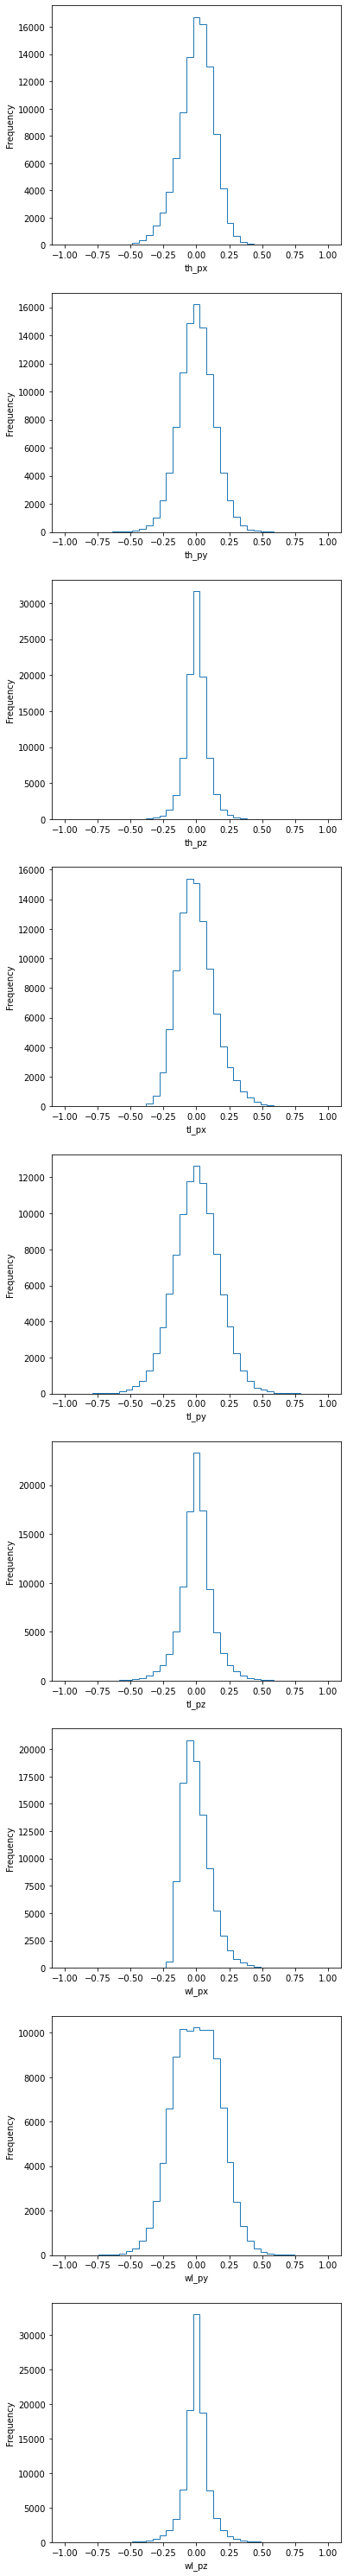

In [4]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Conv11 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Mask)
    Conv12 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Conv11)
    flat_jets = Flatten()(Conv12)
    
    other_input = Input(shape=(trainX_other.shape[1], trainX_other.shape[2]))
    Conv21 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(other_input)
    Conv22 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Conv21)
    flat_other = Flatten()(Conv22)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(512, activation='relu')(concat)
    dense2 = Dense(256, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=1e-6)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4, 64)        256         input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 1024

# del X_total
# del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=True, callbacks=[callback],
                   batch_size=512)

Train on 64000 samples, validate on 16000 samples
Epoch 1/1024
64000/64000 [==============================] - 3s 52us/sample - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 3/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 5/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 6/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 7/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0236 - mse: 0.0236 

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 116/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 117/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 118/1024
64000/64000 [==============================] - 1s 12us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 119/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 120/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 121/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 122/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 230/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 231/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 232/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 233/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 234/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 235/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 236/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 344/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 345/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 346/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 347/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 348/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 349/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 350/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 458/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 459/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 460/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 461/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 462/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 463/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 464/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 572/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 573/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 574/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 575/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 576/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 577/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 578/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 686/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 687/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 688/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 689/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 690/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 691/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 692/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 800/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 801/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 802/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 803/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 804/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 805/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 806/1024

64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 914/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 915/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 916/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 917/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 918/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 919/1024
64000/64000 [==============================] - 1s 13us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 920/1024

Text(0.5, 1.0, 'MSE loss')

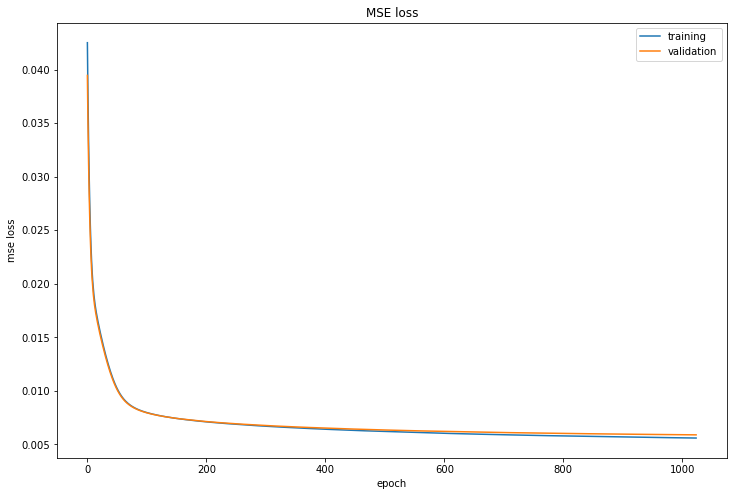

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [9]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [10]:
display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [11]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.005911768287298998
 
th_px MSE :  0.0074622076
th_py MSE :  0.0105315848
th_pz MSE :  0.0026455146
tl_px MSE :  0.0054633770
tl_py MSE :  0.0126698067
tl_pz MSE :  0.0031672608
wl_px MSE :  0.0019157170
wl_py MSE :  0.0075014565
wl_pz MSE :  0.0018489895


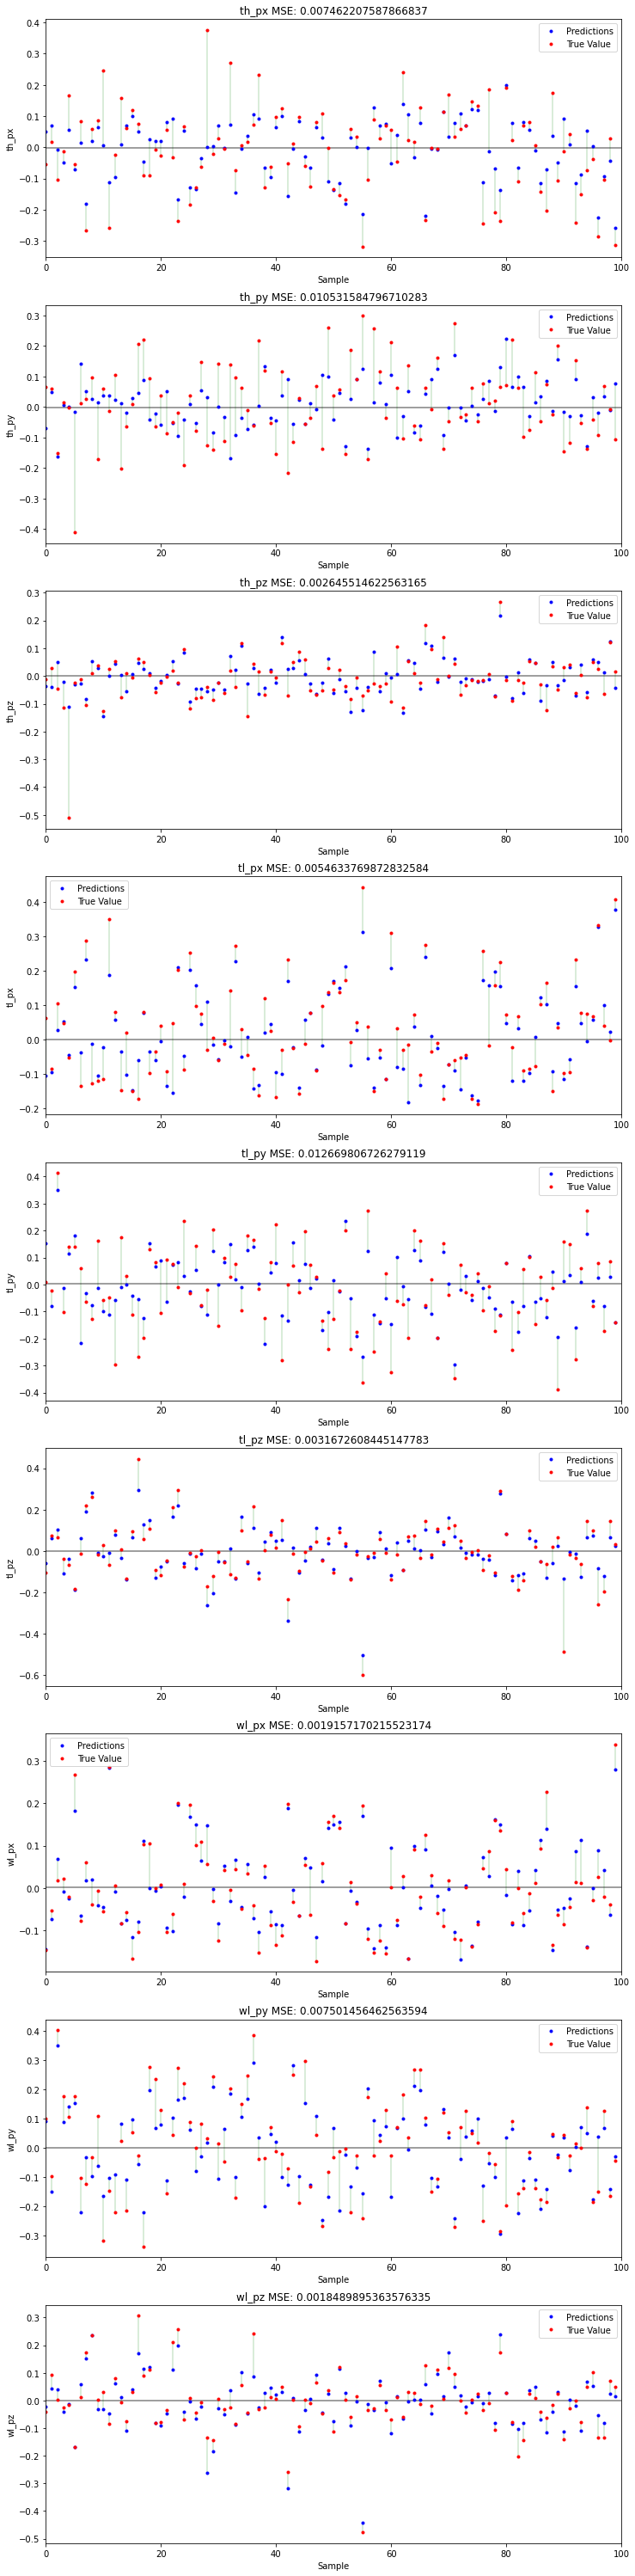

In [12]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

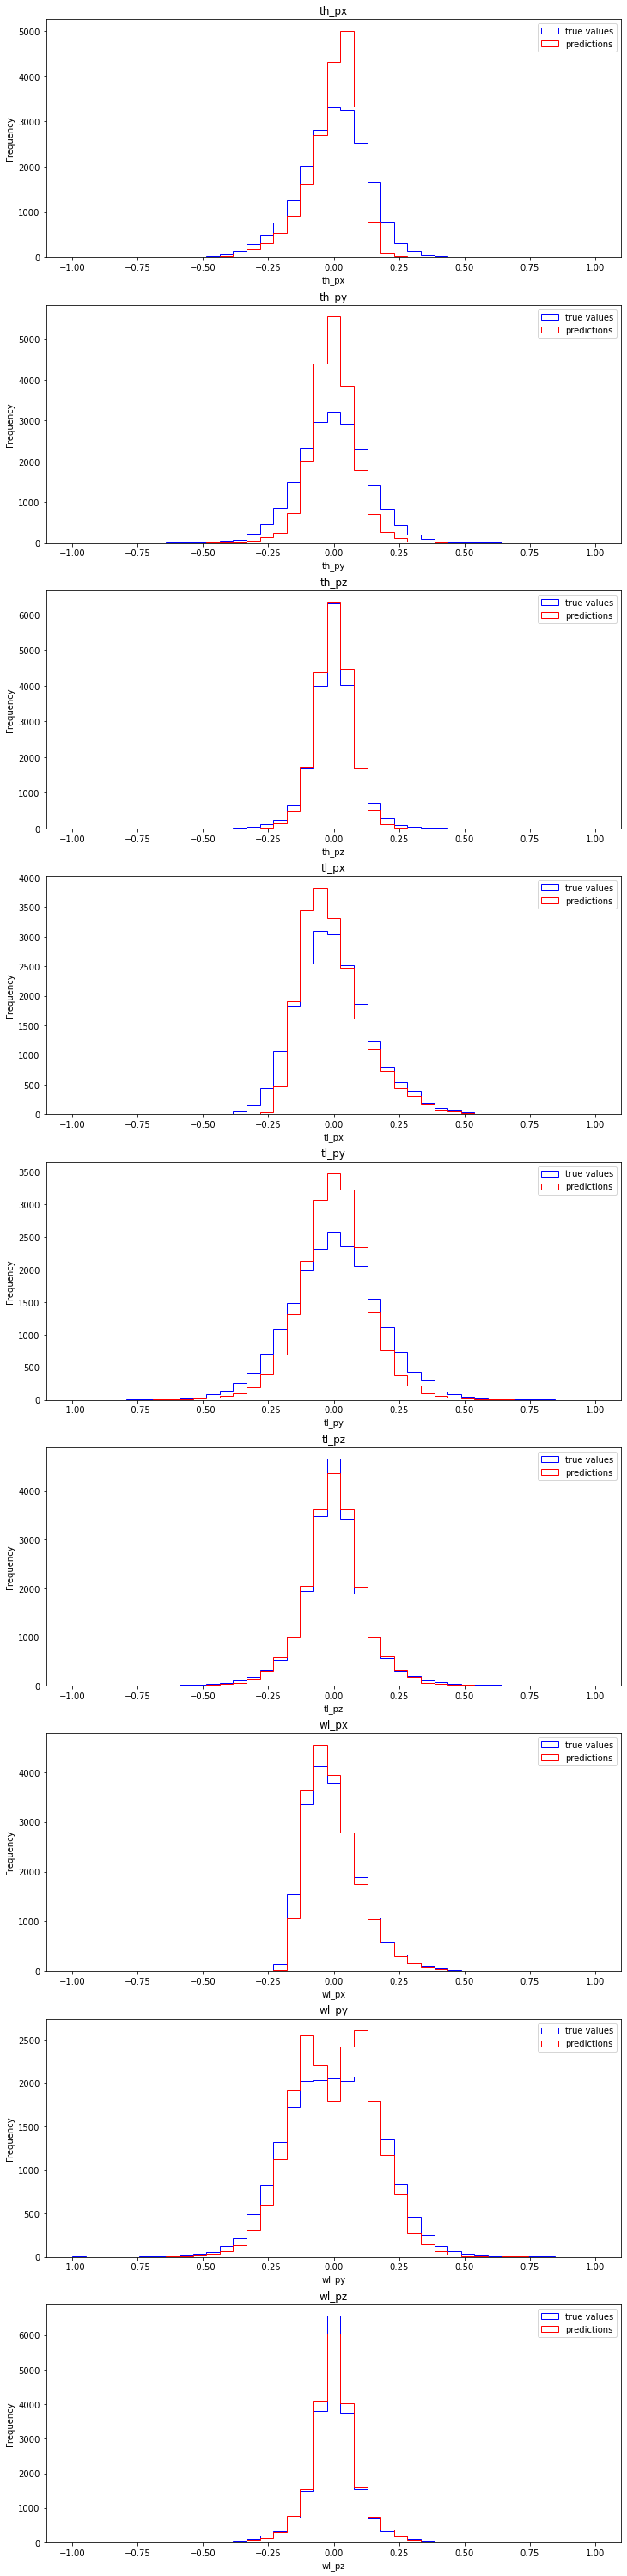

In [13]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

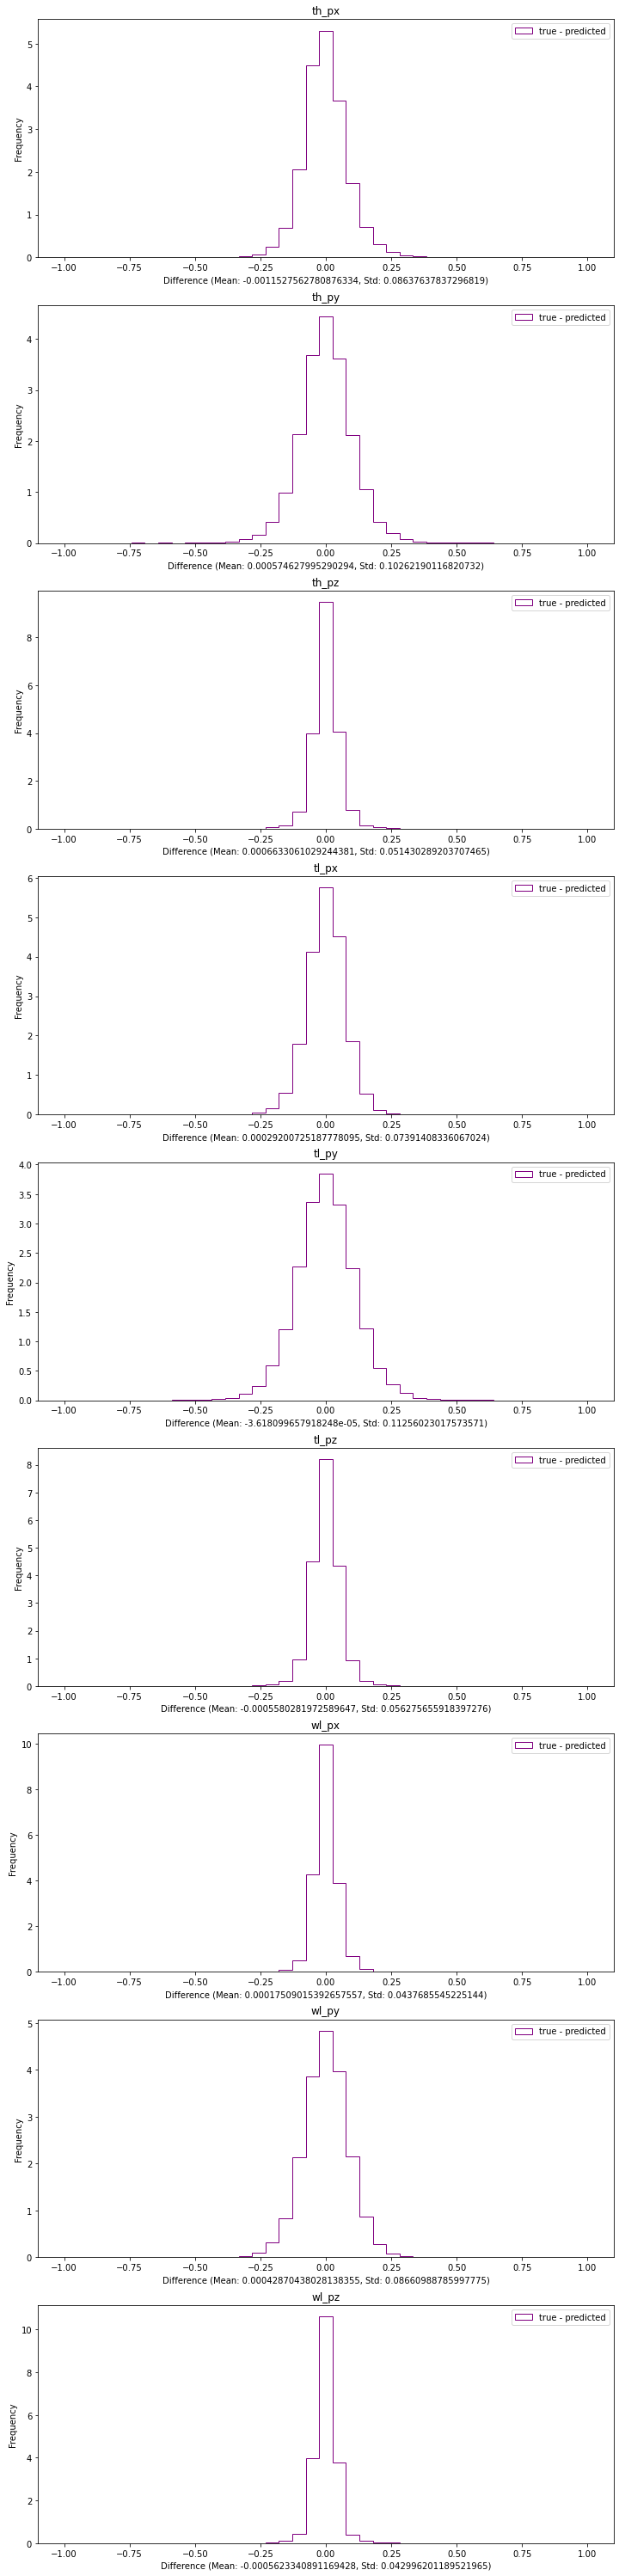

In [14]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

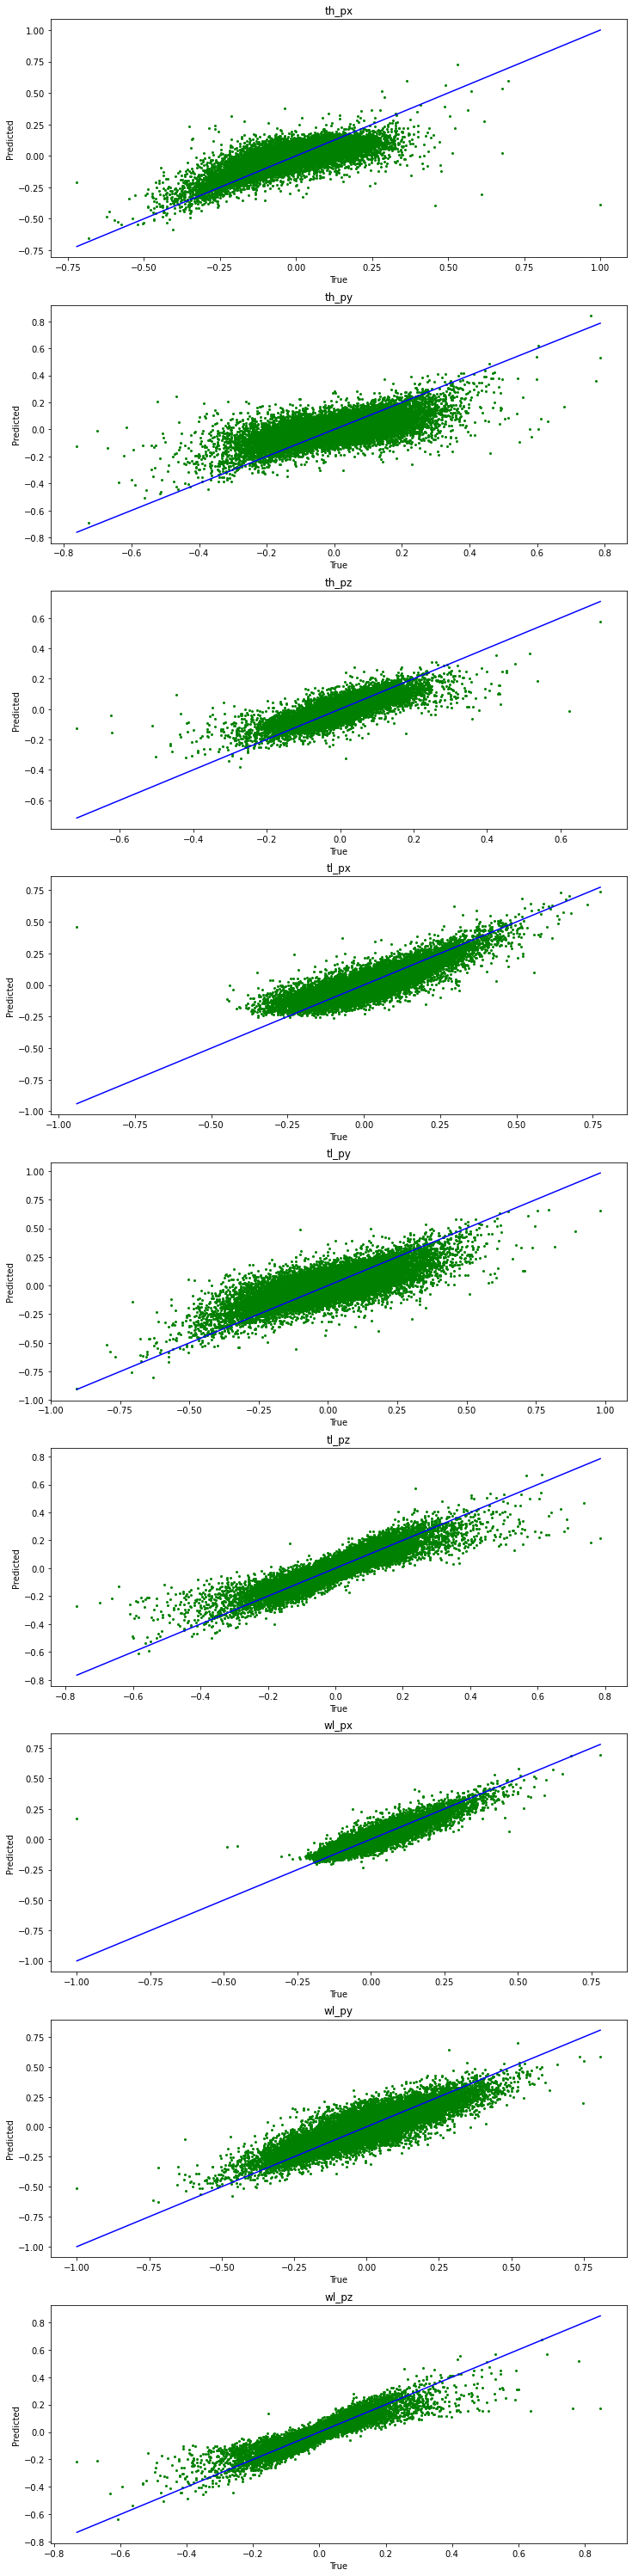

In [15]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [16]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 722.8726808628514
 
th_pt MSE :  3686.5660487797
th_eta MSE :  1.4646373264
th_phi MSE :  1.0481749334
tl_pt MSE :  2133.0469298070
tl_eta MSE :  0.7348325518
tl_phi MSE :  0.6458932581
wl_pt MSE :  676.2379743373
wl_eta MSE :  0.4347933547
wl_phi MSE :  0.2132656211


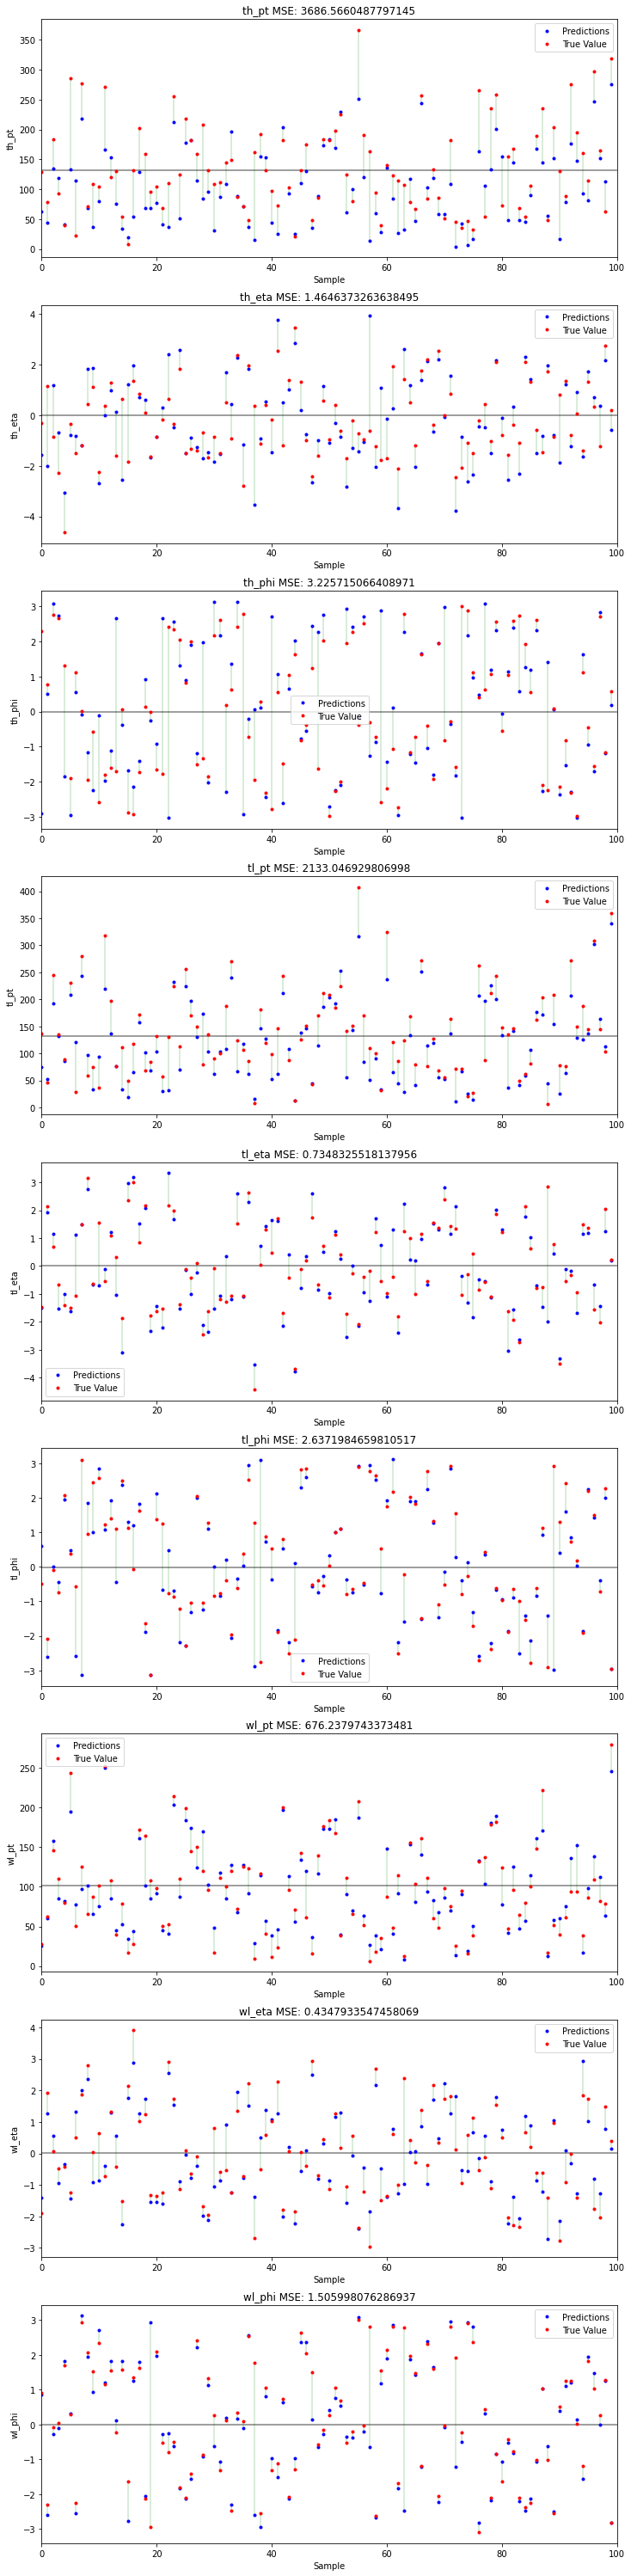

In [17]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

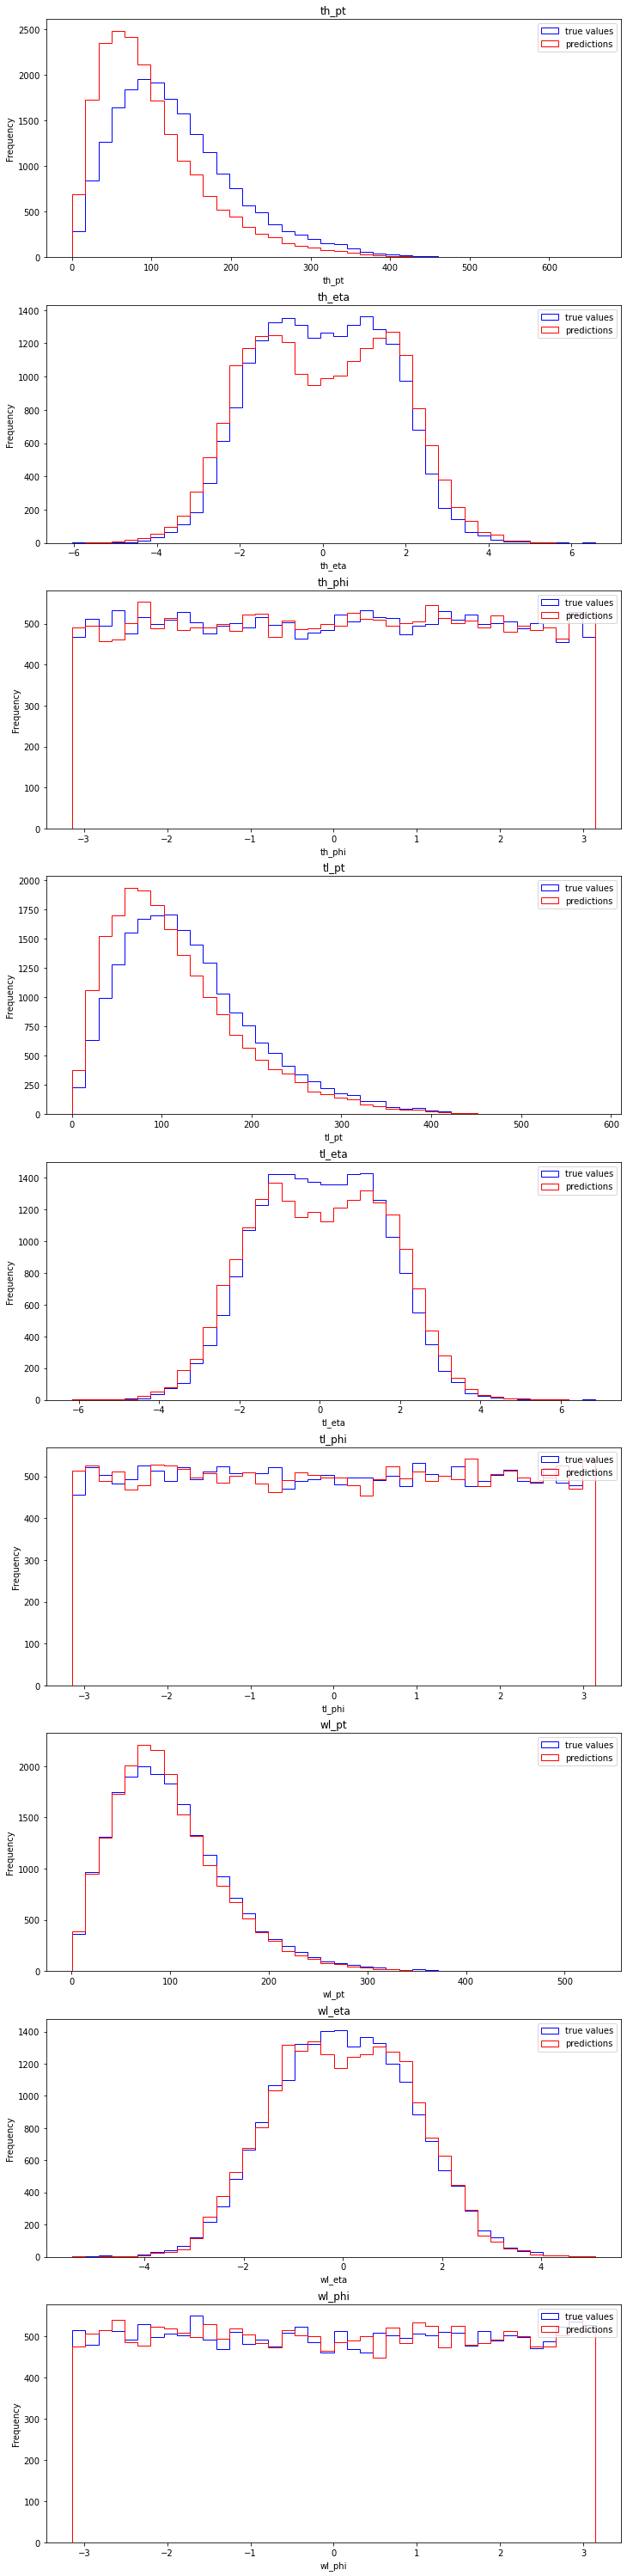

In [18]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

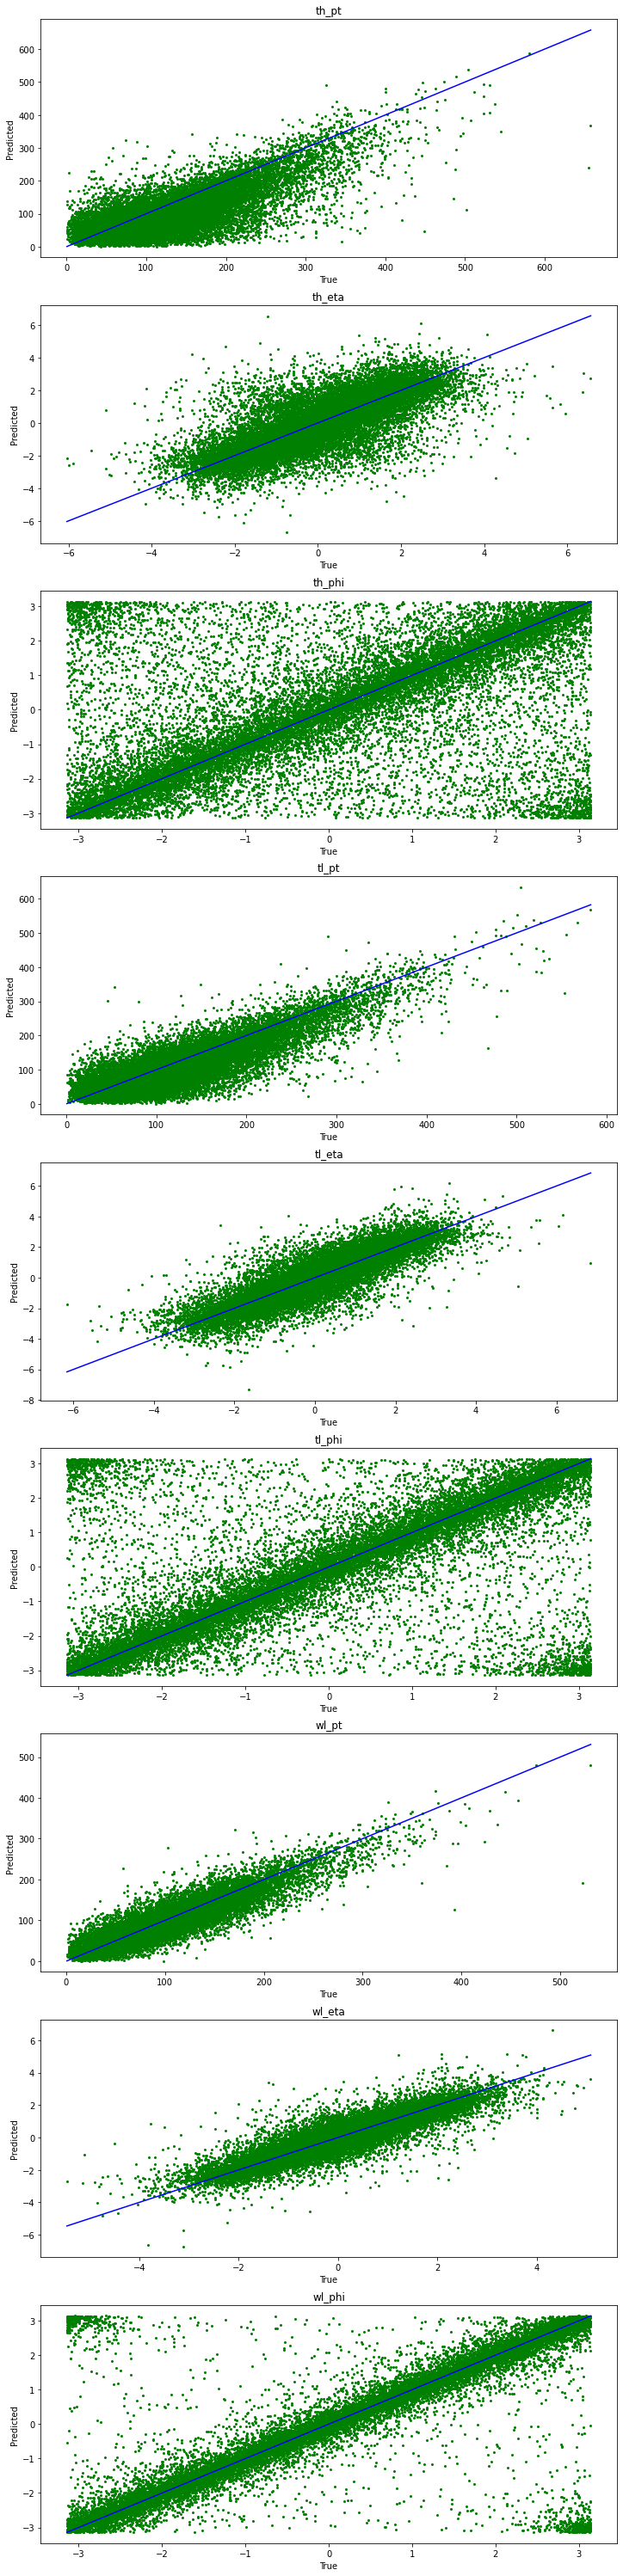

In [19]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)